<a href="https://colab.research.google.com/github/sorman04/Hurdle/blob/master/Lorentzia3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install seaborn -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Stock Analysis Report:
   Stock Predicted Return (%) Confidence Interval Annualized Volatility (%)  \
0   AAPL                 0.02     (-0.32%, 0.36%)                     21.47   
1   MSFT                 0.56     (-0.01%, 1.12%)                     22.75   
2  GOOGL                 0.69      (0.04%, 1.34%)                     28.81   
3   AMZN                 2.36      (1.60%, 3.12%)                     30.73   
4   META                 1.51      (0.86%, 2.16%)                     38.50   

     RSI BB Position  
0  95.84        0.88  
1  79.51        1.03  
2  53.34        0.57  
3  76.86        1.12  
4  84.56        1.02  


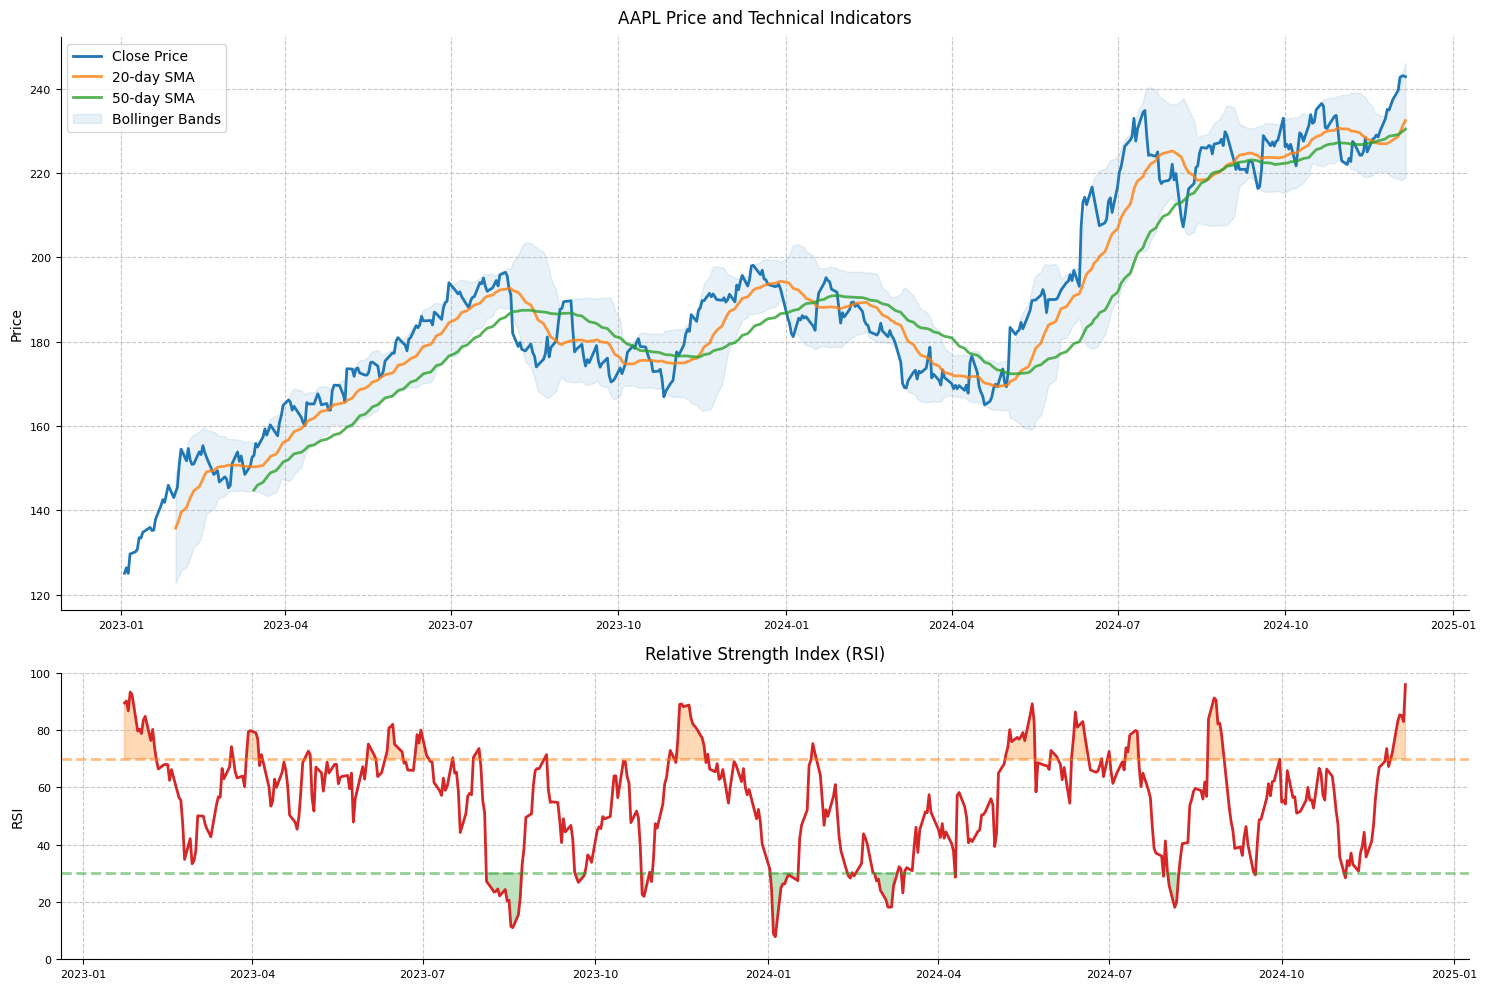

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime, timedelta

class StockAnalyzer:
    def __init__(self, tickers, start_date, end_date):
        """
        Initialize the StockAnalyzer with the given parameters.

        Parameters:
        tickers (list): List of stock ticker symbols
        start_date (str): Start date in 'YYYY-MM-DD' format
        end_date (str): End date in 'YYYY-MM-DD' format
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.results = {}

    def get_clean_financial_data(self, ticker):
        """Download and clean financial data for a given ticker."""
        try:
            data = yf.download(ticker, start=self.start_date, end=self.end_date, progress=False)
            data.columns = data.columns.get_level_values(0)
            data = data.ffill()
            data.index = data.index.tz_localize(None)
            return data
        except Exception as e:
            print(f"Error downloading data for {ticker}: {str(e)}")
            return None

    @staticmethod
    def calculate_technical_indicators(data):
        """Calculate various technical indicators."""
        # Simple Moving Averages
        data['SMA_20'] = data['Close'].rolling(window=20).mean()
        data['SMA_50'] = data['Close'].rolling(window=50).mean()

        # Relative Strength Index (RSI)
        delta = data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        data['RSI'] = 100 - (100 / (1 + rs))

        # Bollinger Bands
        data['BB_middle'] = data['Close'].rolling(window=20).mean()
        data['BB_upper'] = data['BB_middle'] + 2 * data['Close'].rolling(window=20).std()
        data['BB_lower'] = data['BB_middle'] - 2 * data['Close'].rolling(window=20).std()

        return data

    @staticmethod
    def lorentzian_distance(x, y):
        """Calculate Lorentzian distance between two points."""
        return np.log(1 + (x - y)**2)

    def calculate_volatility_metrics(self, data_returns):
        """Calculate various volatility metrics."""
        volatility = data_returns.std() * np.sqrt(252)  # Annualized volatility
        skewness = stats.skew(data_returns)
        kurtosis = stats.kurtosis(data_returns)

        return {
            'volatility': volatility,
            'skewness': skewness,
            'kurtosis': kurtosis
        }

    def predict_next_return(self, data_returns, lorentzian_distances, threshold):
        """Predict next day's return with confidence metrics."""
        if len(data_returns) < 2:
            return None, "Insufficient data for prediction"

        recent_distance = self.lorentzian_distance(data_returns.iloc[-2], data_returns.iloc[-1])

        if recent_distance > threshold:
            return None, "Anomaly detected. Highly volatile return expected."

        # Calculate weighted average of recent returns
        weights = np.exp(-np.arange(len(data_returns[-10:]))[::-1])
        weighted_mean = np.average(data_returns[-10:], weights=weights)

        # Calculate confidence interval
        confidence_level = 0.95
        std_err = data_returns[-30:].std() / np.sqrt(30)
        z_score = stats.norm.ppf((1 + confidence_level) / 2)
        confidence_interval = (
            weighted_mean - z_score * std_err,
            weighted_mean + z_score * std_err
        )

        return {
            'predicted_return': weighted_mean,
            'confidence_interval': confidence_interval,
            'message': "No anomaly detected"
        }

    def analyze_stocks(self):
        """Perform comprehensive analysis on all stocks."""
        for ticker in self.tickers:
            # Get and process data
            data = self.get_clean_financial_data(ticker)
            if data is None:
                continue

            # Calculate returns and technical indicators
            data = self.calculate_technical_indicators(data)
            data_returns = data['Close'].pct_change().dropna()

            # Calculate Lorentzian distances
            lorentzian_distances = [
                self.lorentzian_distance(data_returns.iloc[i], data_returns.iloc[i+1])
                for i in range(len(data_returns)-1)
            ]
            lorentzian_distances = np.array(lorentzian_distances)

            # Calculate threshold
            threshold = lorentzian_distances.mean() + 2 * lorentzian_distances.std()

            # Get prediction and volatility metrics
            prediction = self.predict_next_return(data_returns, lorentzian_distances, threshold)
            volatility_metrics = self.calculate_volatility_metrics(data_returns)

            # Store results
            self.results[ticker] = {
                'prediction': prediction,
                'volatility_metrics': volatility_metrics,
                'technical_indicators': {
                    'last_sma_20': data['SMA_20'].iloc[-1],
                    'last_sma_50': data['SMA_50'].iloc[-1],
                    'last_rsi': data['RSI'].iloc[-1],
                    'last_bb_position': (data['Close'].iloc[-1] - data['BB_lower'].iloc[-1]) /
                                      (data['BB_upper'].iloc[-1] - data['BB_lower'].iloc[-1])
                }
            }

    def generate_report(self):
        """Generate a comprehensive analysis report."""
        report_data = []

        for ticker, analysis in self.results.items():
            pred = analysis['prediction']
            vol_metrics = analysis['volatility_metrics']
            tech_indicators = analysis['technical_indicators']

            if isinstance(pred, dict):
                predicted_return = pred['predicted_return'] * 100
                confidence_low, confidence_high = pred['confidence_interval']
                confidence_range = f"({confidence_low*100:.2f}%, {confidence_high*100:.2f}%)"
            else:
                predicted_return = "Highly Volatile"
                confidence_range = "N/A"

            report_data.append({
                'Stock': ticker,
                'Predicted Return (%)': predicted_return if isinstance(predicted_return, str) else f"{predicted_return:.2f}",
                'Confidence Interval': confidence_range,
                'Annualized Volatility (%)': f"{vol_metrics['volatility']*100:.2f}",
                'RSI': f"{tech_indicators['last_rsi']:.2f}",
                'BB Position': f"{tech_indicators['last_bb_position']:.2f}",
                'Skewness': f"{vol_metrics['skewness']:.2f}",
                'Kurtosis': f"{vol_metrics['kurtosis']:.2f}"
            })

        return pd.DataFrame(report_data)

    def plot_analysis(self, ticker):
        """Generate visualization for a specific stock."""
        try:
            data = self.get_clean_financial_data(ticker)
            if data is None:
                return

            data = self.calculate_technical_indicators(data)

            # Set up the plot
            plt.rcParams['figure.figsize'] = (15, 10)
            plt.rcParams['axes.grid'] = True
            plt.rcParams['lines.linewidth'] = 2

            fig, (ax1, ax2) = plt.subplots(2, 1, height_ratios=[2, 1])

            # Price and indicators plot
            ax1.plot(data.index, data['Close'], label='Close Price', color='#1f77b4')
            ax1.plot(data.index, data['SMA_20'], label='20-day SMA', color='#ff7f0e', alpha=0.8)
            ax1.plot(data.index, data['SMA_50'], label='50-day SMA', color='#2ca02c', alpha=0.8)
            ax1.fill_between(data.index, data['BB_upper'], data['BB_lower'],
                           color='#1f77b4', alpha=0.1, label='Bollinger Bands')

            ax1.set_title(f'{ticker} Price and Technical Indicators', fontsize=12, pad=10)
            ax1.set_ylabel('Price', fontsize=10)
            ax1.legend(loc='upper left', frameon=True)
            ax1.grid(True, linestyle='--', alpha=0.7)

            # RSI plot
            ax2.plot(data.index, data['RSI'], color='#d62728')
            ax2.axhline(y=70, color='#ff7f0e', linestyle='--', alpha=0.5)
            ax2.axhline(y=30, color='#2ca02c', linestyle='--', alpha=0.5)
            ax2.fill_between(data.index, 70, data['RSI'].where(data['RSI'] >= 70),
                           color='#ff7f0e', alpha=0.3)
            ax2.fill_between(data.index, 30, data['RSI'].where(data['RSI'] <= 30),
                           color='#2ca02c', alpha=0.3)
            ax2.set_title('Relative Strength Index (RSI)', fontsize=12, pad=10)
            ax2.set_ylabel('RSI', fontsize=10)
            ax2.set_ylim(0, 100)
            ax2.grid(True, linestyle='--', alpha=0.7)

            # Format x-axis
            for ax in [ax1, ax2]:
                ax.tick_params(axis='both', labelsize=8)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

            plt.tight_layout()
            return fig

        except Exception as e:
            print(f"Error generating plot for {ticker}: {str(e)}")
            return None

if __name__ == "__main__":
    # Define parameters
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']  # Example subset
    start_date = '2023-01-01'
    end_date = datetime.now().strftime('%Y-%m-%d')

    # Initialize and run analysis
    analyzer = StockAnalyzer(tickers, start_date, end_date)
    analyzer.analyze_stocks()

    # Generate and display report
    report = analyzer.generate_report()

    # Remove Skewness and Kurtosis columns before printing
    report = report.drop(columns=['Skewness', 'Kurtosis'], errors='ignore')

    print("\nStock Analysis Report:")
    print(report)

    # Generate plot for a specific stock
    fig = analyzer.plot_analysis('AAPL')
    if fig is not None:
        plt.show()
